In [1]:
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn import preprocessing
from sklearn import decomposition
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sdv

C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('./train_combined_Species.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df = df.fillna(0).drop_duplicates()

def drop_almost_zero(df, percentage):
    column_cut_off = int(percentage/100*len(df))
    b = (df == 0).sum(axis='rows')
    df = df[ b[ b <= column_cut_off].index.values ]

    return df

percentage = 90
df = drop_almost_zero(df,percentage)


inputvalues = df.drop(['label'], axis=1)
outputvalues = df['label']
X, y = inputvalues.values, outputvalues.values
X = X.astype('float32')

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(n_components=19)
X_pca = pca.fit_transform(df_scaled)
#df

import pickle as pk
pk.dump(pca, open("pca.pkl","wb"))
# later reload the pickle file
pca_reload = pk.load(open("pca.pkl",'rb'))
result_new = pca_reload.transform(df_scaled)


### Data preparation

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
#y = y.reshape(-1, 1)
#y = OneHotEncoder(categories=[['0', '1', '2', '3', '4']], sparse=False).fit_transform(y)

#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)



In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
sampler = RandomOverSampler(sampling_strategy='all')
X_train_oversampled, y_train_oversampled = sampler.fit_resample(X_train, y_train)

In [ ]:
from sdv.tabular import CTGAN, GaussianCopula

#scaler = StandardScaler()
#scaler.fit(df)
#X = scaler.transform(df)

df0 = df.loc[(df['label'] == 0)]
df1 = df.loc[df['label'] == 1]
df01 = pd.concat([df0, df1], axis=0)

model = CTGAN()
model.fit(df01)
new_data = model.sample(num_rows=1200)

inputvalues = new_data.drop(['label'], axis=1)
outputvalues = new_data['label']
X_synth, y_synth = inputvalues.values, outputvalues.values
X_synth = X_synth.astype('float32')

X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.2, random_state=1234)
sampler = RandomOverSampler(sampling_strategy='all')
X_train_synth_oversampled, y_train_synth_oversampled = sampler.fit_resample(X_train_synth, y_train_synth)

In [27]:
from statsmodels.discrete.discrete_model import NegativeBinomial
from scipy.stats import nbinom

df0 = df.loc[(df['label'] == 0)]
df1 = df.loc[df['label'] == 1]
df01 = pd.concat([df0, df1], axis=0)

res = sm.NegativeBinomial(y, X).fit()
print(res.summary())

C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1009: RuntimeWarning: overflow encountered in exp
  return stats.poisson.cdf(y, np.exp(X))
C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1333: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1334: RuntimeWarning: invalid value encountered in multiply
  return -np.dot(L*X.T, X)
C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1243: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)


         Current function value: nan
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 2
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                 1006
Model:               NegativeBinomial   Df Residuals:                      116
Method:                           MLE   Df Model:                          889
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:                     nan
Time:                        23:46:49   Log-Likelihood:                    nan
converged:                      False   LL-Null:                       -1161.3
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1                nan        nan        nan        nan         nan         nan
x2   

C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, roc_auc_score, confusion_matrix


clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train_synth, y_train_synth)
y_pred = clf.predict(X_test)
print("Classification Report: \n {}\n".format(metrics.classification_report(y_test, y_pred)))
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred)))

In [8]:
accuracy = sum(y_pred == y_test) / len(y_test)
accuracy

0.448559670781893

### Random Forest

In [41]:
df["label"].value_counts()

0    2126
1     516
2      82
3      41
4      28
Name: label, dtype: int64

In [11]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, confusion_matrix
import imblearn
from sklearn import metrics
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1234)

#Training the model on the training dataset
# with fit-Function to train the model using the training sets as parameters
clf.fit(X_train, y_train)  # type: ignore
#performing predictions on the test dataset
y_pred = clf.predict(X_test)

feature_names = df.drop(['label'], axis=1).columns
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index = feature_names)
t = forest_importances.sort_values(ascending=False)
print(t)

# metrics are used to find accuracy or error
print()
a = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy of the model based on accuracy of test set: {a: .4f}")
print(f"Error of test set: {1 - a:.4f}")
b = clf.oob_score_
print(f"Out of bag score (samples in training set): {b:.4f}")
print(f"out-of-bag error (samples in training set): {1 - b:.4f}")
print(f"Accuracy of Training set: {clf.score(X_train, y_train) :.4f}")
print("Classification Report: \n {}\n".format(metrics.classification_report(y_test, y_pred)))
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred)))
#print("ROC AUC: {0:.4f}\n".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
#RocCurveDisplay.from_estimator(clf, X_test, y_test, name="Random Forest", multi_class=[''])
#plt.show()
'''
roc = {label: [] for label in multi_class_series.unique()}
for label in multi_class_series.unique():
    selected_classifier.fit(train_set_dataframe, train_class == label)
    predictions_proba = selected_classifier.predict_proba(test_set_dataframe)
    roc[label] += roc_auc_score(test_class, predictions_proba[:,1])
'''

t

Bacteria;Firmicutes;Clostridia;Monoglobales;Monoglobaceae;Monoglobus;uncultured bacterium.156                              0.002563
Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;Bacteroides fragilis CL07T12C05.2               0.002248
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Escherichia-Shigella;Escherichia coli.7    0.002063
Bacteria;Firmicutes;Bacilli;RF39;uncultured bacterium.158                                                                  0.001883
Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Rikenellaceae;Alistipes;uncultured bacterium.156                           0.001882
                                                                                                                             ...   
Bacteria;Firmicutes;Clostridia;Eubacteriales;Anaerofustaceae;Anaerofustis;uncultured bacterium.3                           0.000000
Bacteria;Firmicutes;Clostridia;Lachnospirales;Lachnospiraceae;uncultured;unc

C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Bacteria;Firmicutes;Clostridia;Monoglobales;Monoglobaceae;Monoglobus;uncultured bacterium.156                              0.002563
Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;Bacteroides fragilis CL07T12C05.2               0.002248
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Escherichia-Shigella;Escherichia coli.7    0.002063
Bacteria;Firmicutes;Bacilli;RF39;uncultured bacterium.158                                                                  0.001883
Bacteria;Bacteroidota;Bacteroidia;Bacteroidales;Rikenellaceae;Alistipes;uncultured bacterium.156                           0.001882
                                                                                                                             ...   
Bacteria;Firmicutes;Clostridia;Eubacteriales;Anaerofustaceae;Anaerofustis;uncultured bacterium.3                           0.000000
Bacteria;Firmicutes;Clostridia;Lachnospirales;Lachnospiraceae;uncultured;unc

C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 1136, in f1_sco

Mean f1: nan
Mean recall: nan
Mean precision: nan


C:\Users\Flo13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


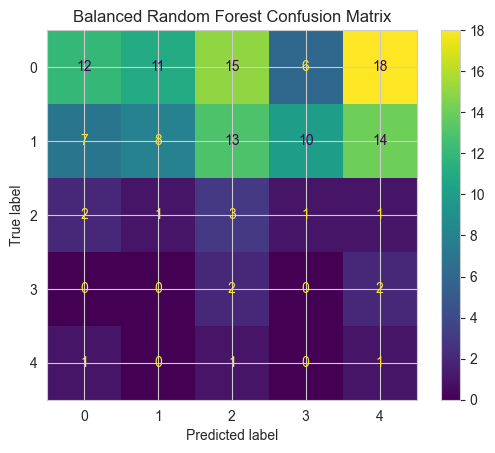

In [24]:
#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier

df_without = df.drop(['sample_ID'], axis=1)
X = df_without.drop(["label"], axis=1)
y = df_without["label"]
#X = preprocessing.normalize(X)

#Build SRF model
BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=1234)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
scoring = ('f1', 'recall', 'precision')
#Evaluate BRFC model
scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#Train BRFC
BRFC.fit(X_train, y_train.values.ravel())
#BRFC prediction result
y_pred = BRFC.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(BRFC, X_test, y_test)
plt.title('Balanced Random Forest Confusion Matrix')
plt.show()